In [ ]:
!pip install --upgrade numpy
!pip install --upgrade --force-reinstall gensim
!pip install pandas==2.0.3 # Install a compatible version of pandas to align with gensim

In [ ]:
!pip install gensim

from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
import gensim
import sys
import numpy as np
import pandas as pd
import string
import logging
import random
import matplotlib.pyplot as plt

# Loading dataset
df = pd.read_csv('/content/drive/MyDrive/articles.csv')
df = df.dropna(subset=['text']).iloc[:, [1, 3]]

# Create an iterator object that returns words properly formatted for Word2Vec training
class NewsIterator:
    def __init__(self, dataset):
        self.dataset = dataset

        # The text contains a stupid special character, hence the + '–'
        self.translator = str.maketrans('', '', string.punctuation + '–')

    def __iter__(self):
        for news in self.dataset.iloc[:, 0]:
            # Make all characters lower-case
            news = news.lower()
            for sentence in news.split('.')[:-1]:
                # Clean string of all punctuation
                sentence = sentence.translate(self.translator)

                words = [w for w in sentence.split(' ') if w != '']

                yield words

sentences = NewsIterator(df)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Word2Vec Model

In [ ]:
w2v_model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=10, workers=8)
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

# Some validation on the quality of the Word2Vec model
print(w2v_model.wv.most_similar('1', topn=3))
print(w2v_model.wv.most_similar('janeiro', topn=3))
print(w2v_model.wv.most_similar('palmeiras', topn=3))
print(w2v_model.wv.most_similar('ufsc', topn=3))
print(w2v_model.wv.most_similar(positive=['rei', 'mulher'], negative=['homem'], topn=3))

def word2token(word):
    try:
        return w2v_model.wv.key_to_index[word] # Changed from vocab to key_to_index
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index_to_key[token] # Changed from index2word to index_to_key

Vocabulary Size: 98932 - Embedding Dim: 100
[('2', 0.9076139330863953), ('3', 0.8720777034759521), ('4', 0.8194442987442017)]
[('agosto', 0.8233303427696228), ('julho', 0.8130102157592773), ('abril', 0.8124083876609802)]
[('corinthians', 0.9781225919723511), ('grêmio', 0.9154376983642578), ('flamengo', 0.9142934083938599)]
[('ufpr', 0.843667209148407), ('ufmg', 0.824810266494751), ('unifesp', 0.8112832307815552)]
[('rainha', 0.6702920198440552), ('esposa', 0.6490154266357422), ('namorada', 0.6234050393104553)]


## Visualizing Word2Vec Embeddings with t-SNE

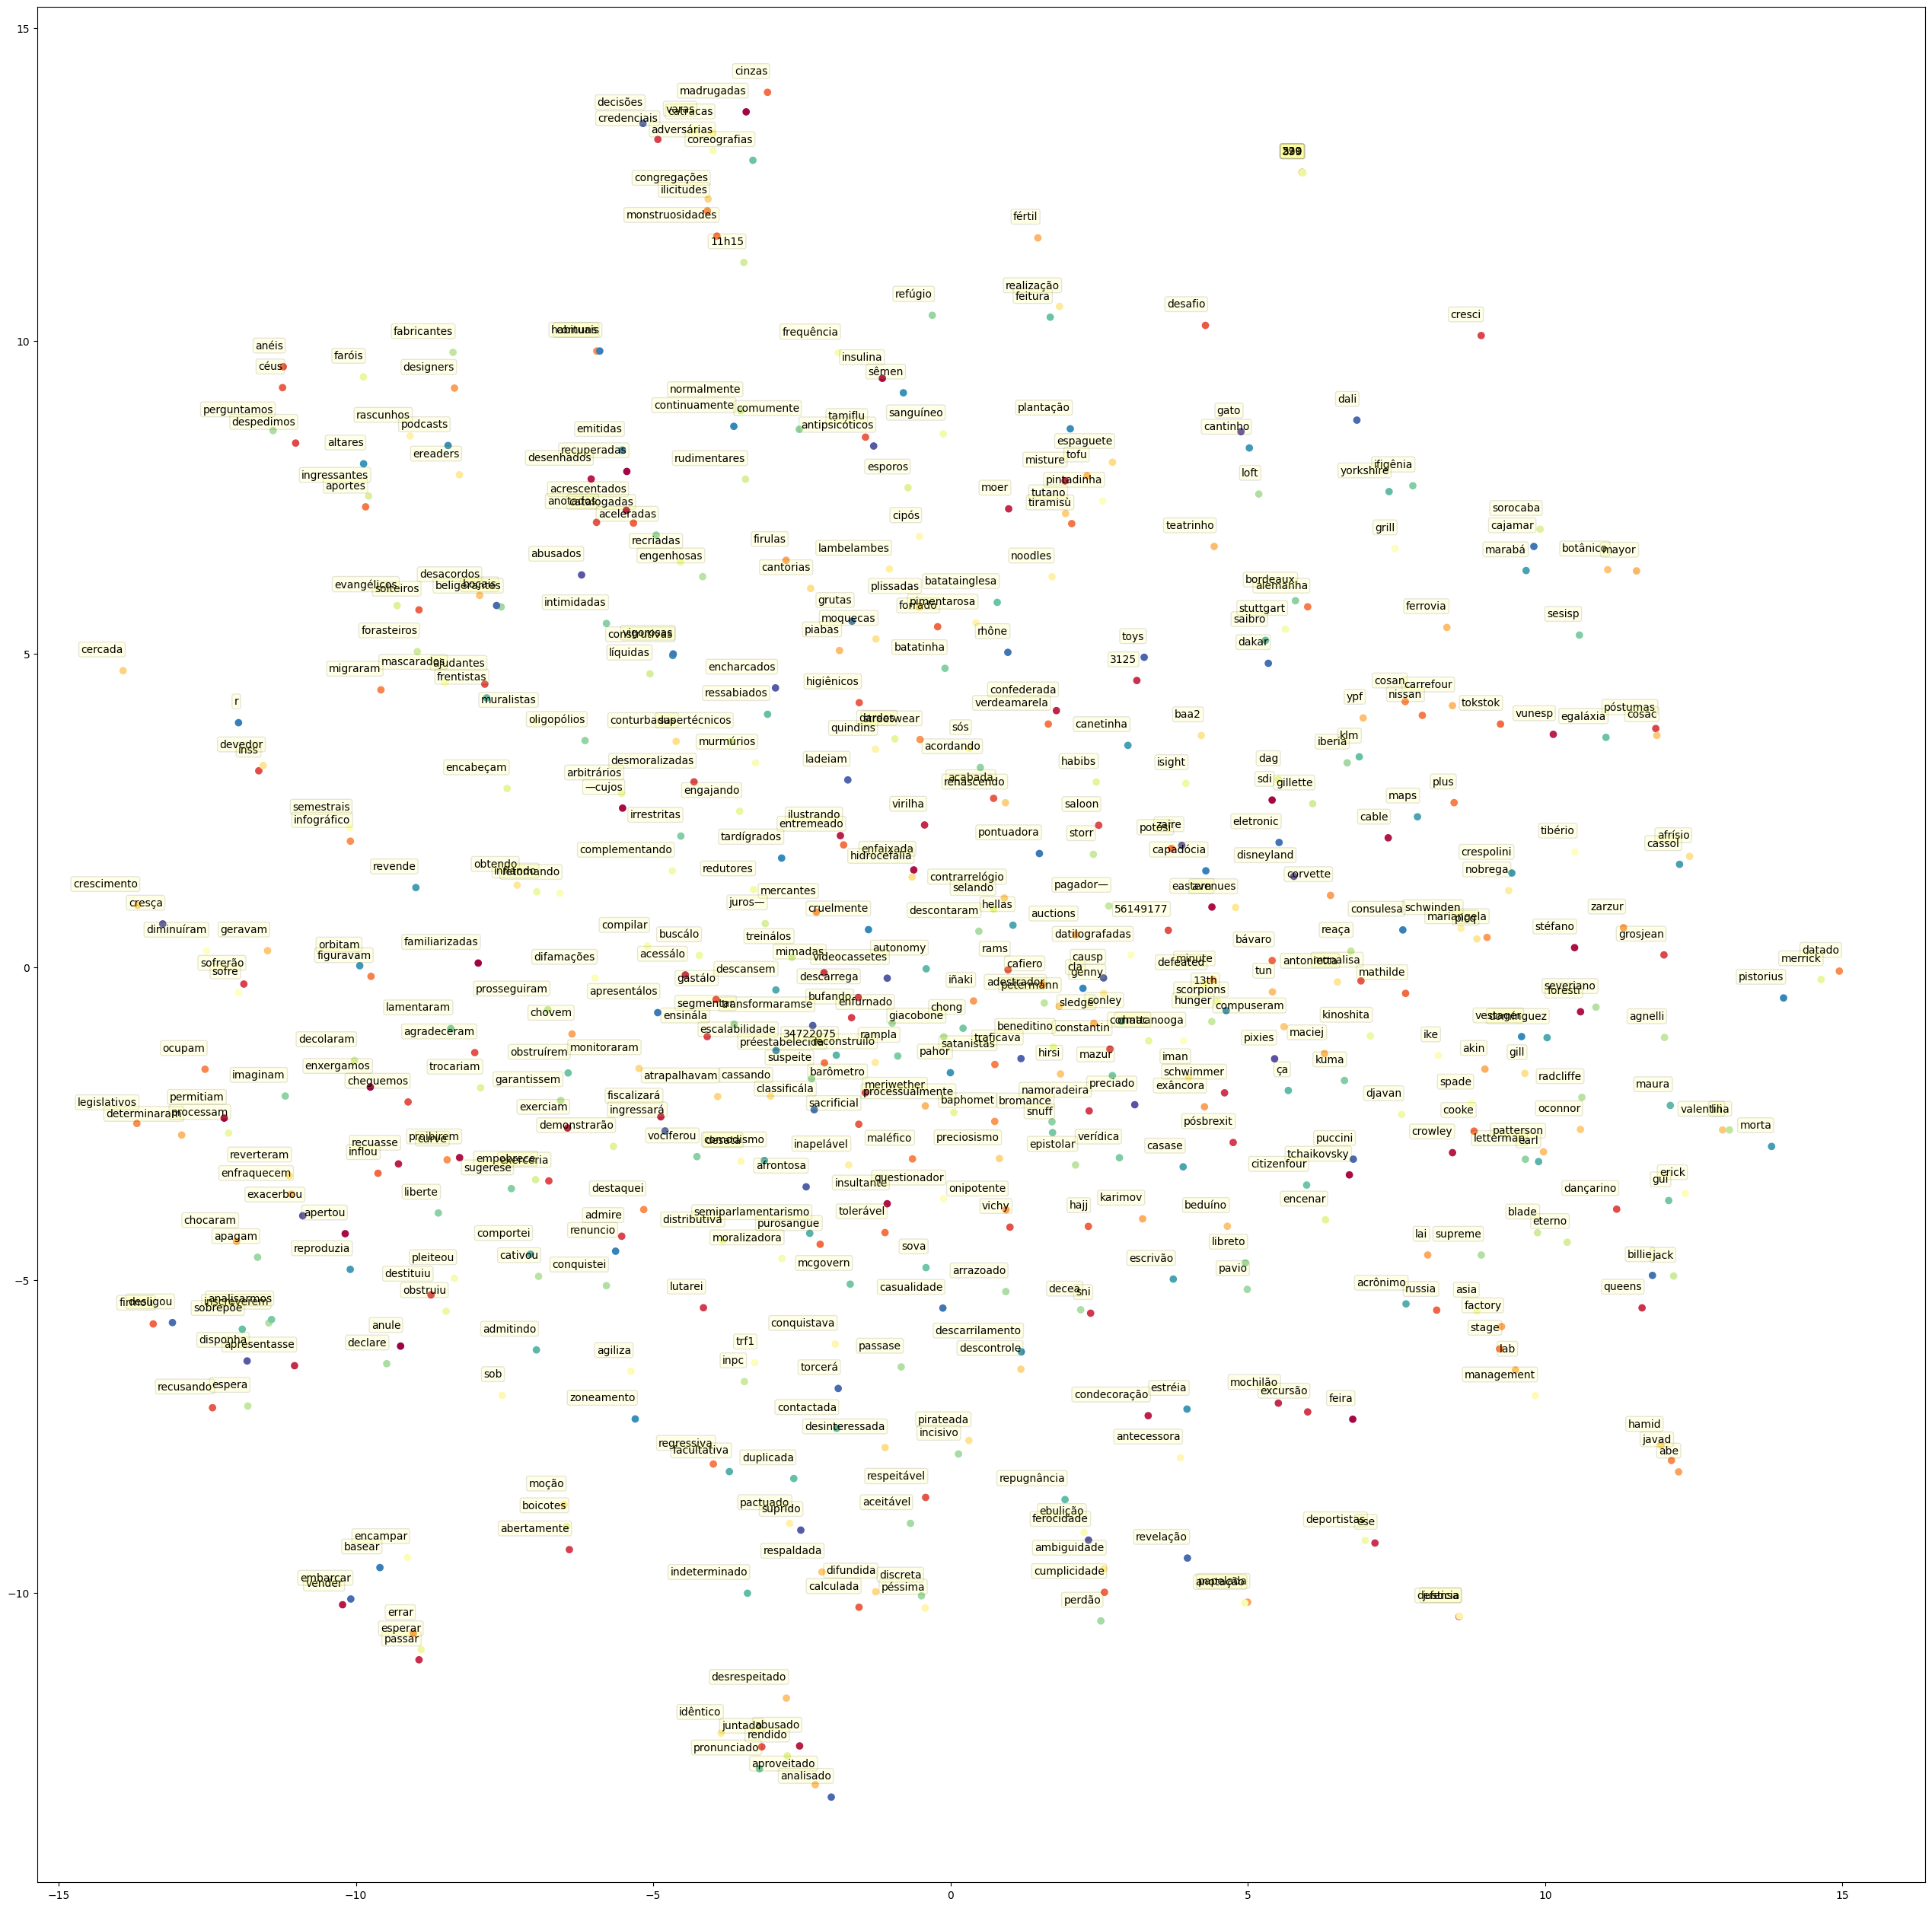

In [ ]:
from sklearn.manifold import TSNE

n_samples = 500
# Sample random words from model dictionary
random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]
word_vecs = np.array([w2v_model.wv[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

# Plot t-SNE result
plt.figure(figsize=(32, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

## Preparing data as sequences for LSTM

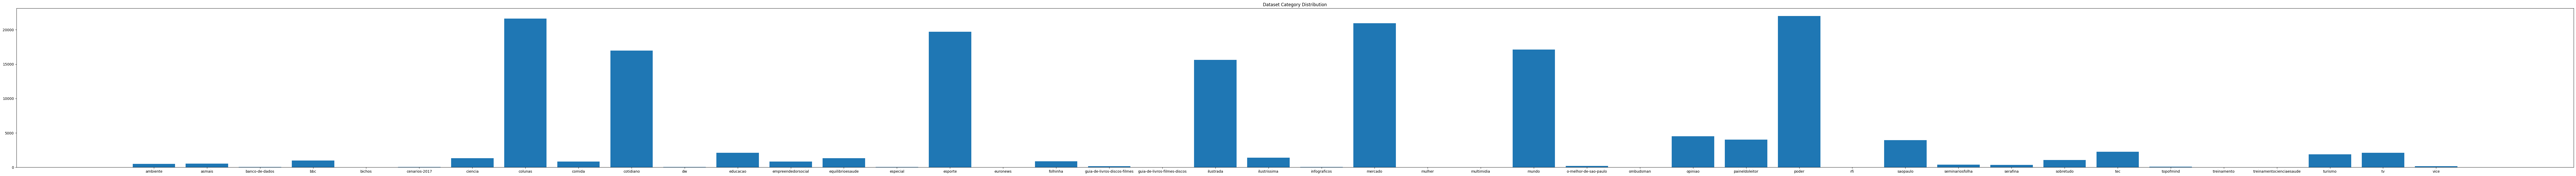

In [ ]:
categories, ccount = np.unique(df.category, return_counts=True)
plt.figure(figsize=(128, 8))
plt.title("Dataset Category Distribution")
plt.bar(categories, ccount, align='center')
plt.show()


In [ ]:
MAX_SEQUENCE_LENGTH = 200

# Samples of categories with less than this number of samples will be ignored
DROP_THRESHOLD = 10000

class SequenceIterator:
    def __init__(self, dataset, drop_threshold, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.categories, self.ccount = np.unique(dataset.category, return_counts=True)

        self.seq_length = seq_length

        # Samples of categories with less than this number of samples will be ignored
        self.drop_categos = []
        for cat, count in zip(self.categories, self.ccount):
            if count < drop_threshold:
                self.drop_categos.append(cat)

        # Remaining categories
        self.categories = np.setdiff1d(self.categories, self.drop_categos)

    def __iter__(self):
        for news, cat in zip(self.dataset.iloc[:, 0], self.dataset.iloc[:, 1]):
            if cat in self.drop_categos:
                continue

            # Make all characters lower-case
            news = news.lower()

            # Clean string of all punctuation
            news = news.translate(self.translator)

            words = np.array([word2token(w) for w in news.split(' ')[:self.seq_length] if w != ''])

            yield (words, cat)

sequences = SequenceIterator(df, DROP_THRESHOLD, MAX_SEQUENCE_LENGTH)

# Used for generating the labels in the set
cat_dict = {k: v for k, v in zip(sequences.categories, range(len(sequences.categories)))}

set_x = []
set_y = []
for w, c in sequences:
    set_x.append(w)
    set_y.append(cat_dict[c])

# Padding sequences with 0.
set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_y = np.array(set_y)

print(set_x.shape)
print(set_y.shape)

(134055, 200)
(134055,)


## Splitting dataset in training and validation

Train Shapes - X: (113947, 200) - Y: (113947,)
Val Shapes - X: (20108, 200) - Y: (20108,)


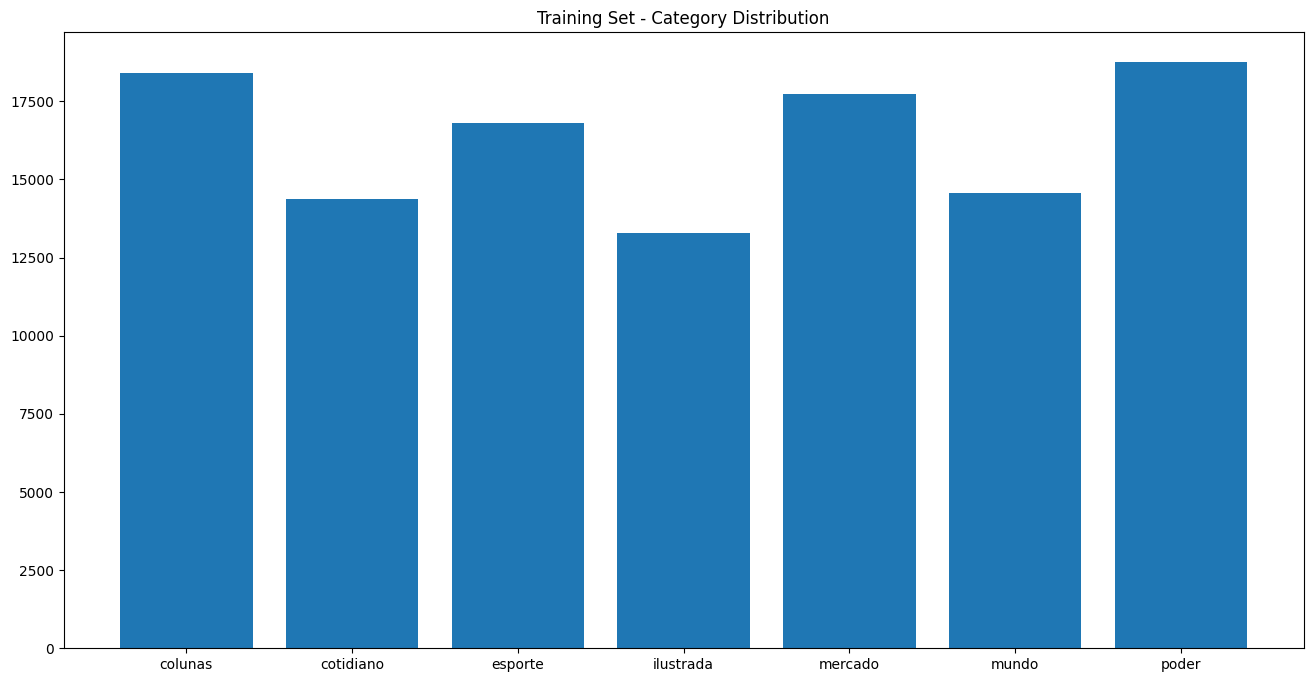

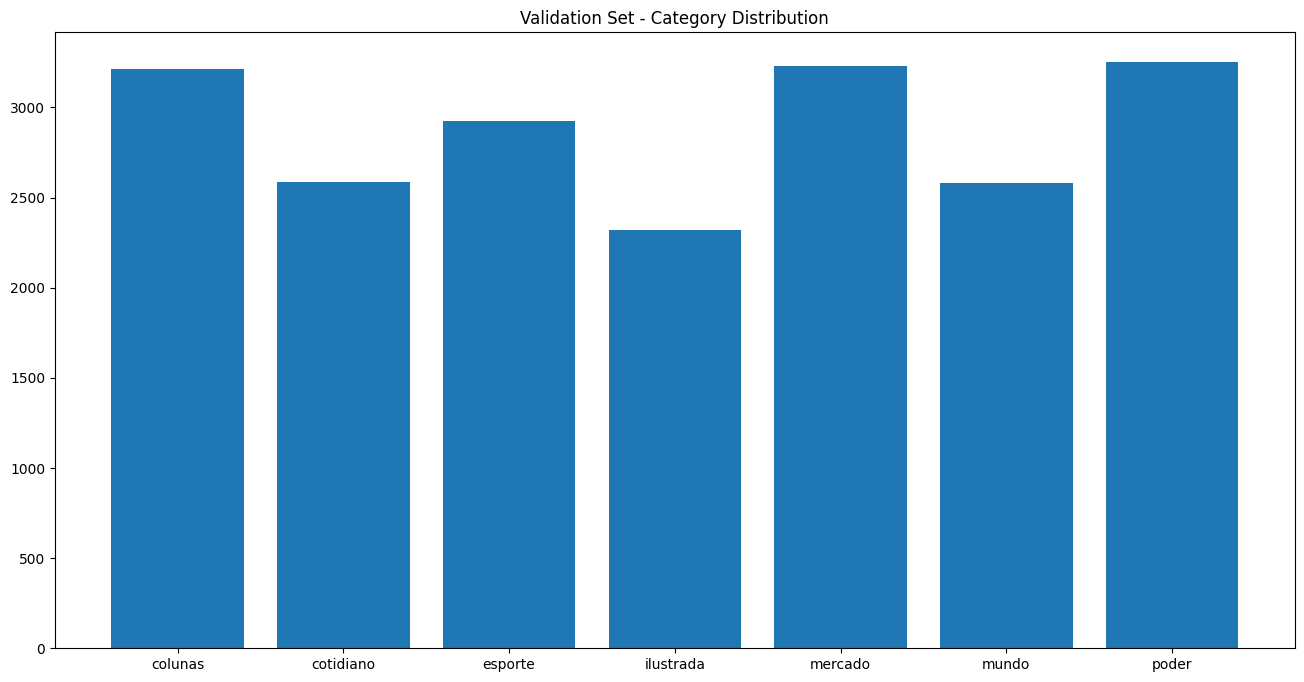

In [ ]:
VALID_PER = 0.15

total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

random_i = random.sample(range(total_samples), total_samples)
train_x = set_x[random_i[:n_train]]
train_y = set_y[random_i[:n_train]]
val_x = set_x[random_i[n_train:n_train+n_val]]
val_y = set_y[random_i[n_train:n_train+n_val]]

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))

# Let's look at the distribution of categories in both sets
categories, ccount = np.unique(train_y, return_counts=True)
plt.figure(figsize=(16, 8))
plt.title("Training Set - Category Distribution")
plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(categories, ccount, align='center')
plt.show()

categories, ccount = np.unique(val_y, return_counts=True)
plt.figure(figsize=(16, 8))
plt.title("Validation Set - Category Distribution")
plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(categories, ccount, align='center')
plt.show()

n_categories = len(categories)

## Defining and Training LSTM Model



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
MAX_SEQUENCE_LENGTH = 50
train_x = pad_sequences(train_x, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
val_x = pad_sequences(val_x, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

model = Sequential()

model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

# Optimized LSTM layers
model.add(Bidirectional(LSTM(50, return_sequences=False)))  # Reduced units
model.add(Dropout(0.2))  # Add dropout
model.add(Dense(n_categories, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Train model
history = model.fit(train_x, train_y, epochs=5, batch_size=128,  # Increased batch size
                    validation_data=(val_x, val_y), verbose=1,
                    callbacks=[early_stopping])

# Print model summary for insight
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
891/891 ━━━━━━━━━━━━━━━━━━━━ 145s 154ms/step - accuracy: 0.6119 - loss: 1.0624 - val_accuracy: 0.7502 - val_loss: 0.6884
Epoch 2/5
891/891 ━━━━━━━━━━━━━━━━━━━━ 139s 151ms/step - accuracy: 0.7592 - loss: 0.6665 - val_accuracy: 0.7631 - val_loss: 0.6522
Epoch 3/5
891/891 ━━━━━━━━━━━━━━━━━━━━ 135s 143ms/step - accuracy: 0.7760 - loss: 0.6141 - val_accuracy: 0.7702 - val_loss: 0.6278
Epoch 4/5
891/891 ━━━━━━━━━━━━━━━━━━━━ 147s 150ms/step - accuracy: 0.7877 - loss: 0.5800 - val_accuracy: 0.7714 - val_loss: 0.6244
Epoch 5/5
891/891 ━━━━━━━━━━━━━━━━━━━━ 139s 147ms/step - accuracy: 0.7971 - loss: 0.5534 - val_accuracy: 0.7728 - val_loss: 0.6235


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 100)        │     9,893,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,076,523 (38.44 MB)

 Trainable params: 61,107 (238.70 KB)

 Non-trainable params: 9,893,200 (37.74 MB)

 Optimizer params: 122,216 (477.41 KB)

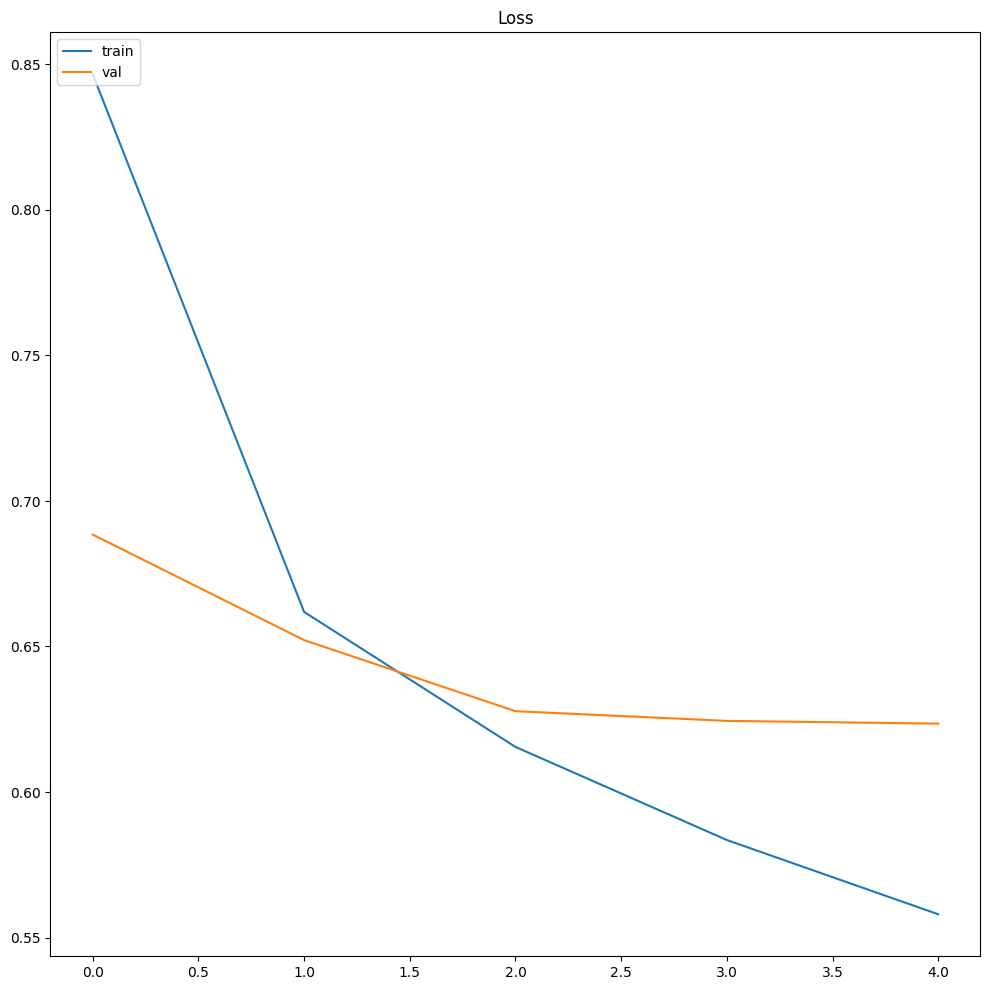

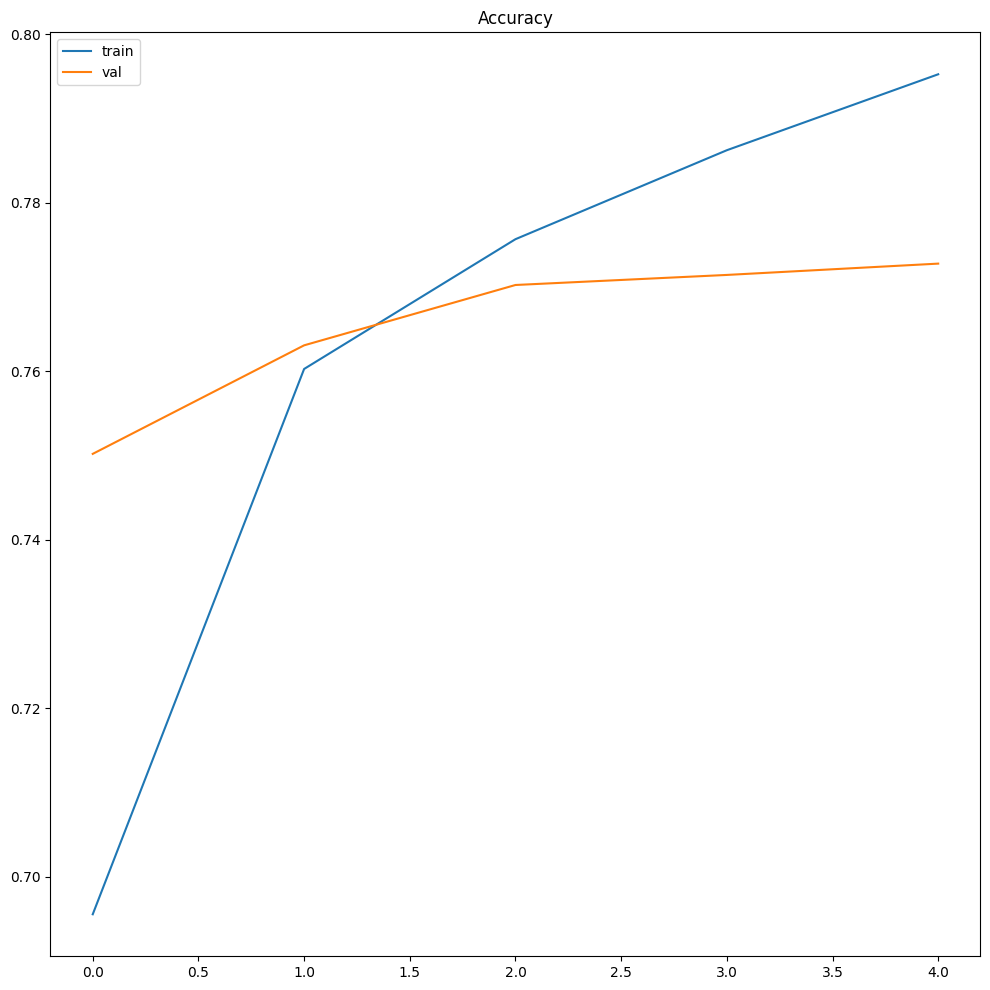

In [ ]:
# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()